In [1]:
import os
import glob
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_ccle_nn_weight_decay_range'
)

num_genes = 8000
seed = 42
plot_gene = 'KRAS'

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'generalization_plots', 'nn_results'
)

In [3]:
weight_decay_dfs = {}

for weight_decay_file in glob.glob(
    os.path.join(results_dir,
                 plot_gene,
                 f'{plot_gene}_signal_mad_s{seed}_n{num_genes}_w*_classify_learning_curves.tsv.gz')
):
    weight_decay = (
        os.path.basename(weight_decay_file).split('_')[5].replace('w', '')
    )
    weight_decay_df = pd.read_csv(weight_decay_file, sep='\t', index_col=0).reset_index(drop=True)
    weight_decay_df['weight_decay'] = weight_decay
    weight_decay_dfs[weight_decay] = weight_decay_df

print(sorted(list(weight_decay_dfs.keys())))
weight_decay_dfs[list(weight_decay_dfs.keys())[0]].head()

['0.0', '0.001', '0.005', '0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '0.75', '1.0', '10.0']


,epoch,fold,dataset,metric,value,weight_decay
0,1,0,train,aupr,0.484115,0.5
1,2,0,train,aupr,0.606070,0.5
2,3,0,train,aupr,0.654224,0.5
3,4,0,train,aupr,0.681797,0.5
4,5,0,train,aupr,0.677417,0.5


[0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 10.0]


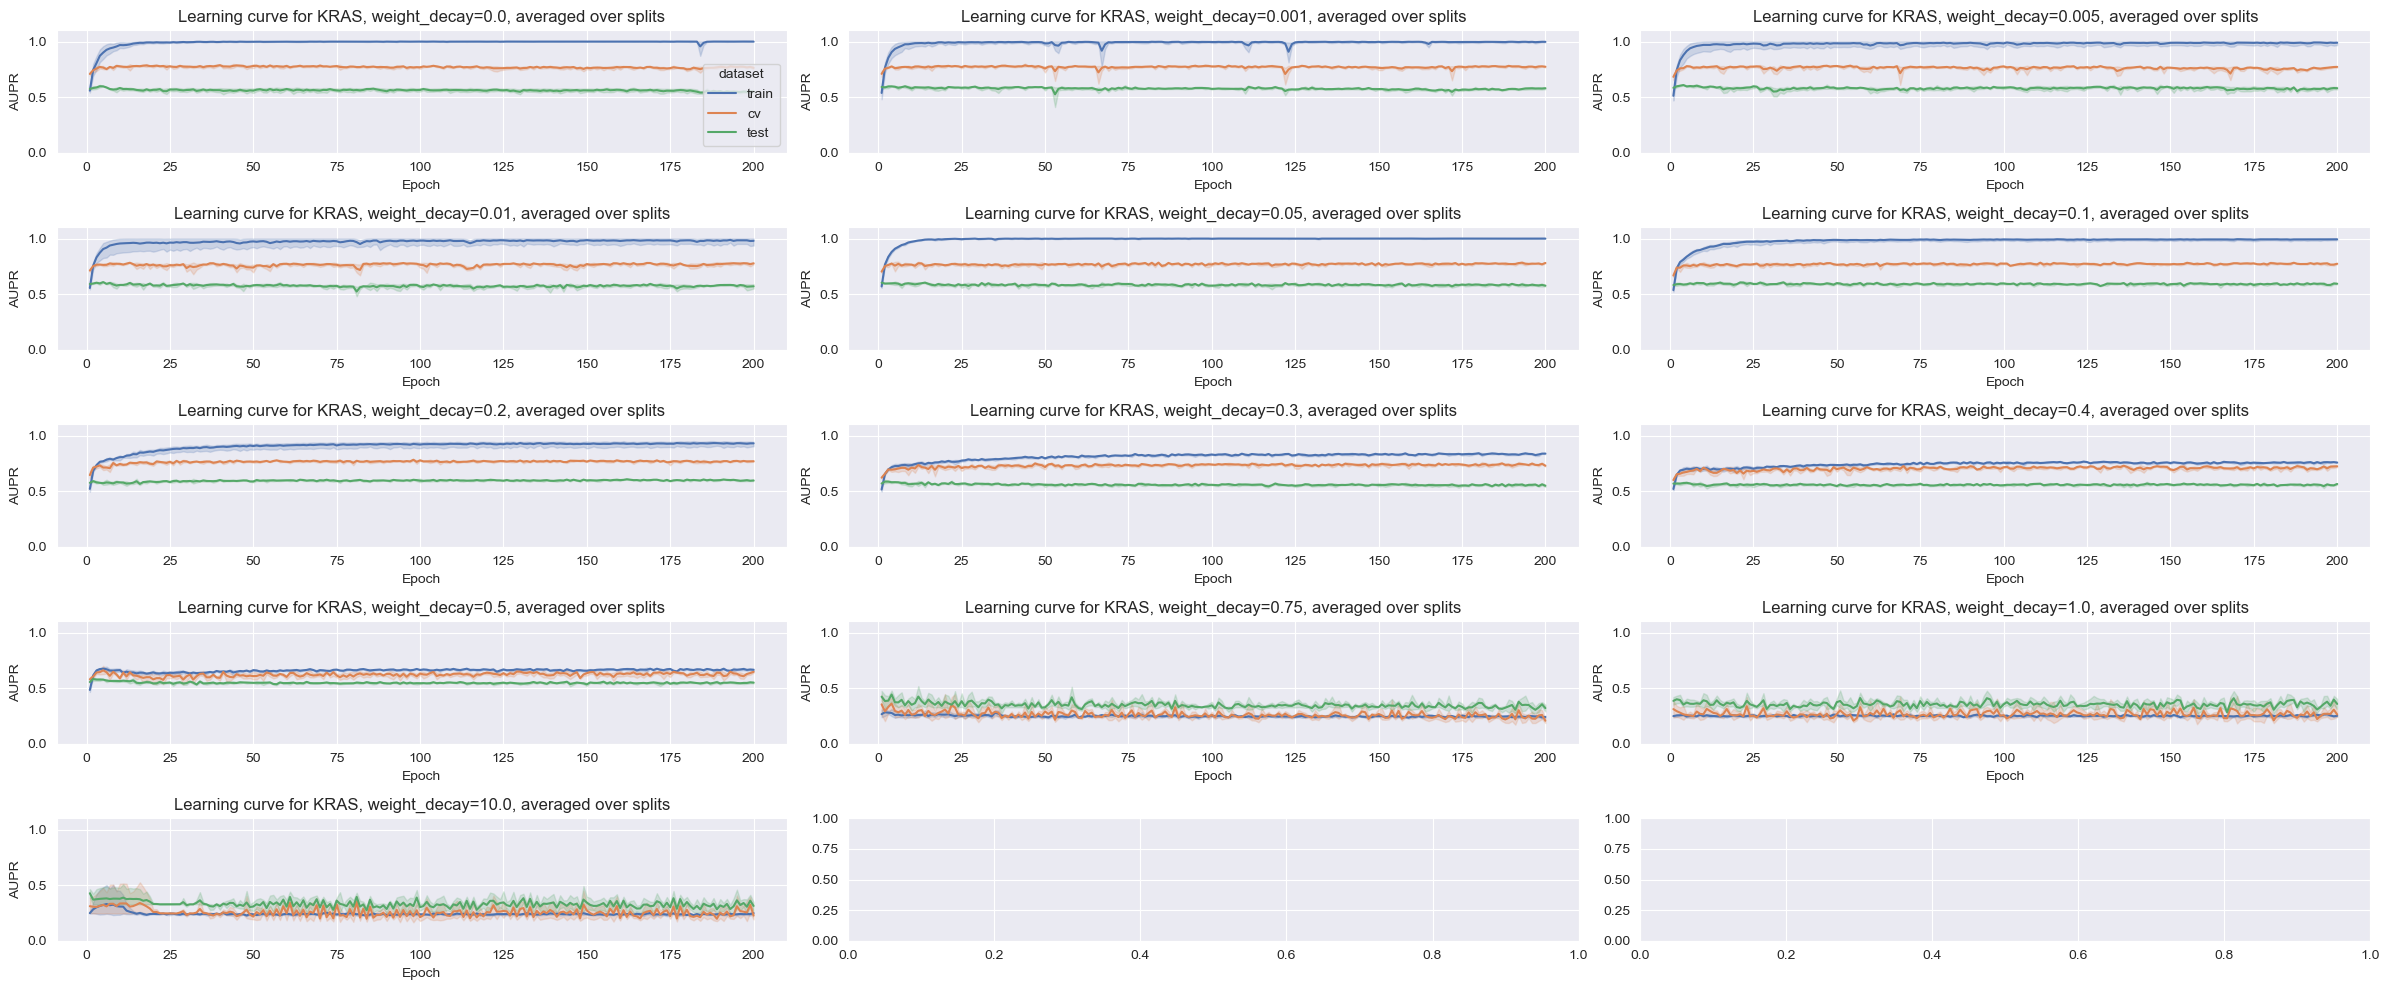

In [4]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

weight_decay_vals = sorted(list([float(k) for k in weight_decay_dfs.keys()]))
print(weight_decay_vals)

fig, axarr = plt.subplots(ceil(len(weight_decay_vals) / 3), 3)

for ix, weight_decay in enumerate(weight_decay_vals):
    ax = axarr[ix // 3, ix % 3]
    if ix == 0:
        sns.lineplot(data=weight_decay_dfs[str(weight_decay)], x='epoch', y='value', hue='dataset', ax=ax)
    else:
        sns.lineplot(data=weight_decay_dfs[str(weight_decay)], x='epoch', y='value', hue='dataset', legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, weight_decay={weight_decay}, averaged over splits')
    
plt.tight_layout()

[0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 10.0]


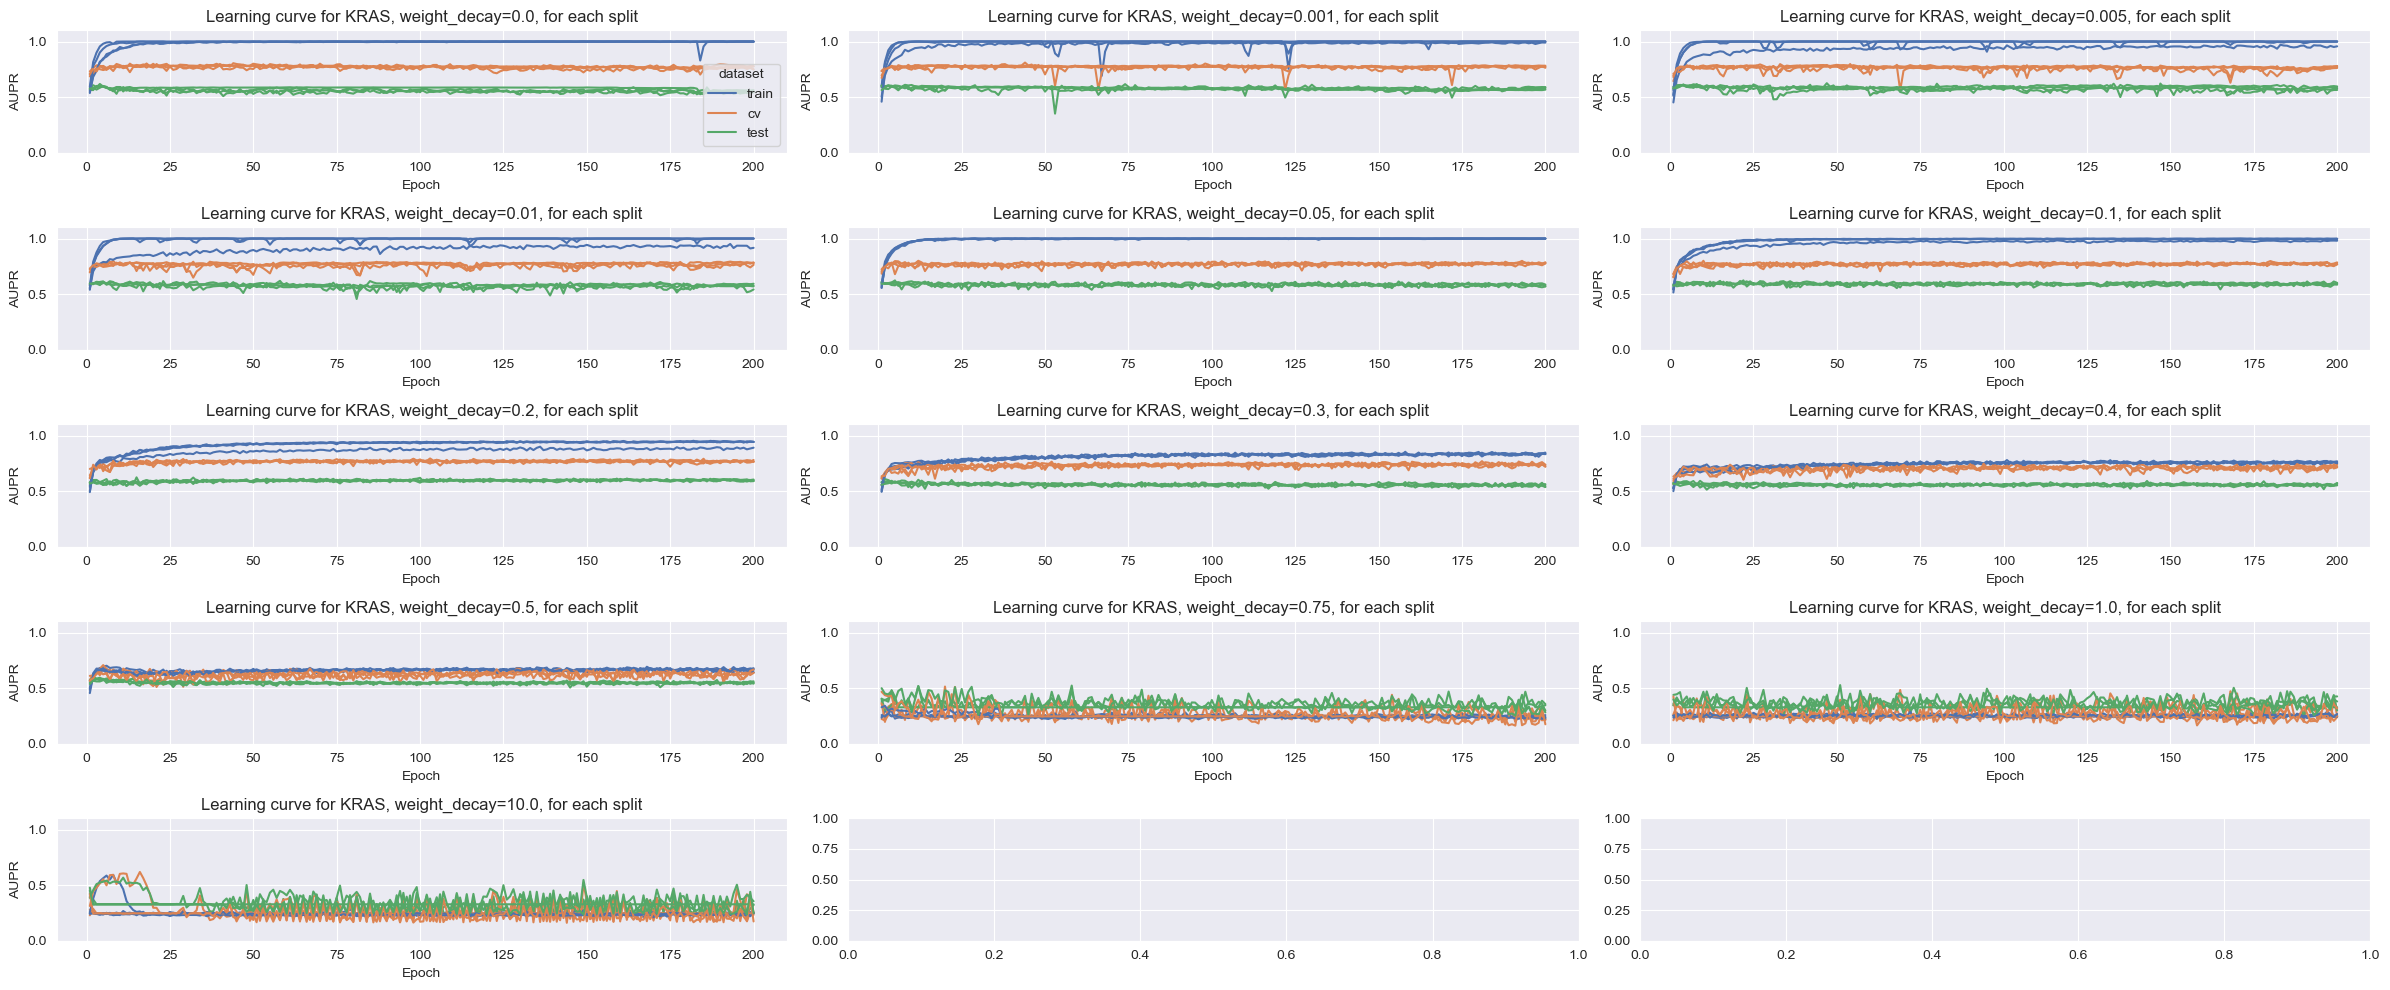

In [5]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

weight_decay_vals = sorted(list([float(k) for k in weight_decay_dfs.keys()]))
print(weight_decay_vals)

fig, axarr = plt.subplots(ceil(len(weight_decay_vals) / 3), 3)

for weight_decay_ix, weight_decay in enumerate(weight_decay_vals):
    ax = axarr[weight_decay_ix // 3, weight_decay_ix % 3]
    weight_decay_df = weight_decay_dfs[str(weight_decay)]
    for fold_ix, fold in enumerate(weight_decay_df.fold.unique()):
        if weight_decay_ix == 0 and fold_ix == 0:
            sns.lineplot(data=weight_decay_df[weight_decay_df.fold == fold],
                         x='epoch', y='value', hue='dataset', ax=ax)
        else:
            sns.lineplot(data=weight_decay_df[weight_decay_df.fold == fold],
                         x='epoch', y='value', hue='dataset',
                         legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, weight_decay={weight_decay}, for each split')

plt.tight_layout()

In [6]:
weight_decay_df = pd.concat(weight_decay_dfs.values())
print(weight_decay_df.shape)
weight_decay_df.head()

(31200, 6)


,epoch,fold,dataset,metric,value,weight_decay
0,1,0,train,aupr,0.484115,0.5
1,2,0,train,aupr,0.606070,0.5
2,3,0,train,aupr,0.654224,0.5
3,4,0,train,aupr,0.681797,0.5
4,5,0,train,aupr,0.677417,0.5


In [7]:
last_epoch = weight_decay_df.epoch.max()
perf_df = (weight_decay_df[weight_decay_df.epoch == last_epoch]
    .drop(columns=['epoch'])
)
                      
print(perf_df.shape)
perf_df.head()

(156, 5)


,fold,dataset,metric,value,weight_decay
199,0,train,aupr,0.678845,0.5
399,0,cv,aupr,0.639711,0.5
599,0,test,aupr,0.549348,0.5
799,1,train,aupr,0.672318,0.5
999,1,cv,aupr,0.640678,0.5


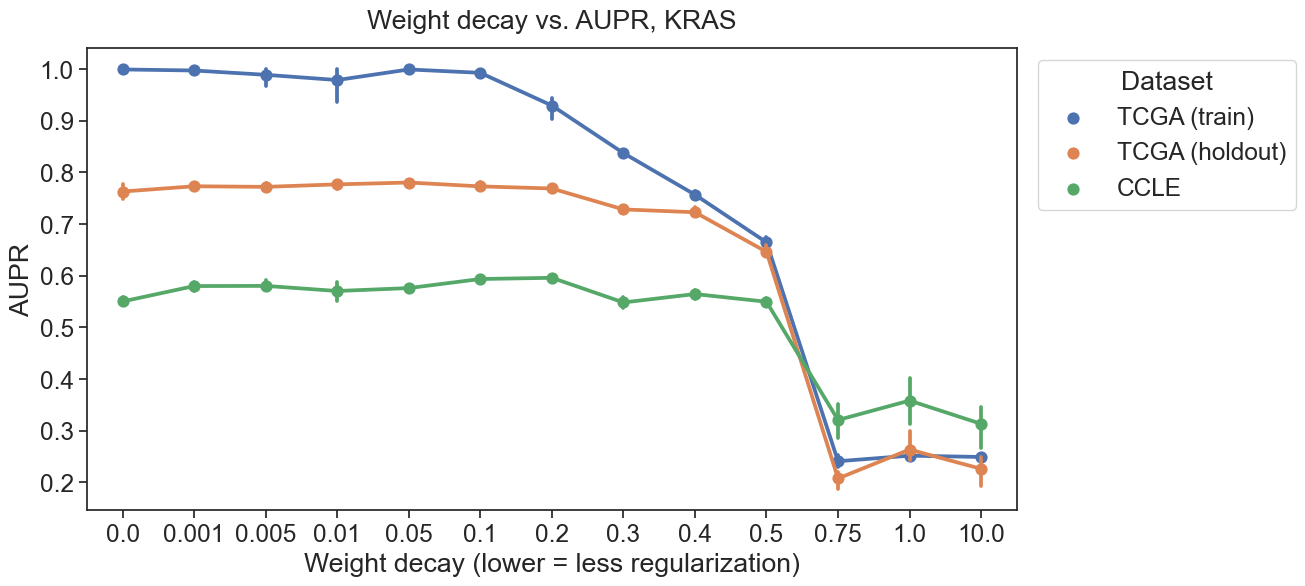

In [8]:
# plot weight decay as a categorical variable vs. performance
sns.set({'figure.figsize': (12, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['weight_decay'])
    .reset_index(drop=True)
)
plot_df.weight_decay = plot_df.weight_decay.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.pointplot(
        data=plot_df,
        x='weight_decay', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set_xlabel(f'Weight decay (lower = less regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Weight decay vs. AUPR, {plot_gene}', y=1.025)

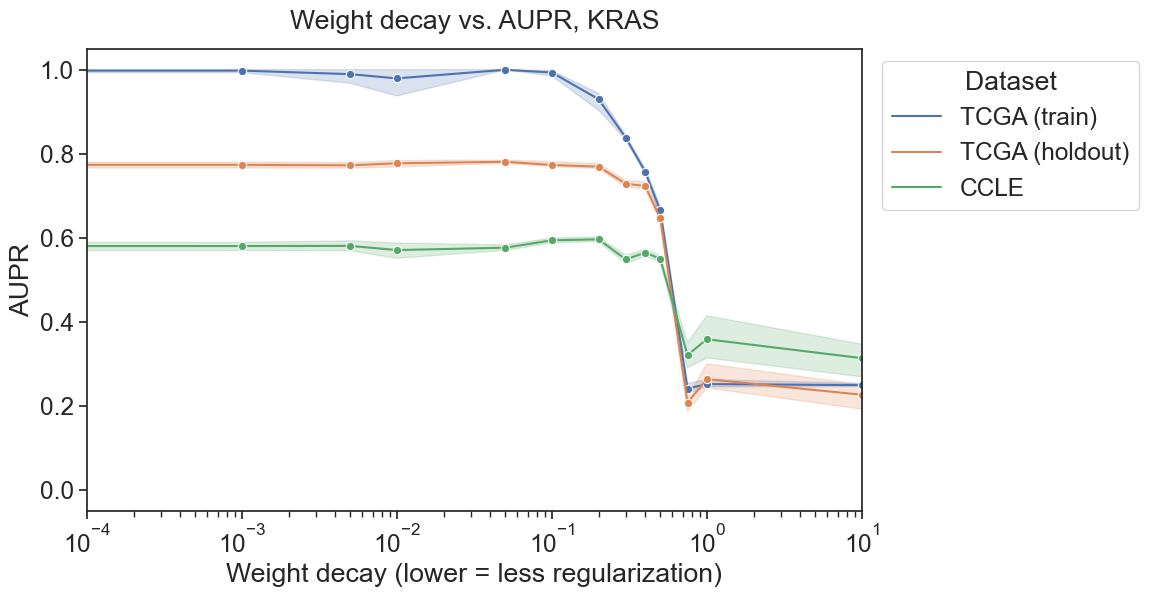

In [9]:
# plot weight decay as a float-valued variable (on a log scale, like LASSO parameter) vs. performance
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['weight_decay'])
    .reset_index(drop=True)
)
plot_df.weight_decay = plot_df.weight_decay.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='weight_decay', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.weight_decay) + 0.0001, max(plot_df.weight_decay)), ylim=(-0.05, 1.05))
    g.set_xlabel(f'Weight decay (lower = less regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Weight decay vs. AUPR, {plot_gene}', y=1.025)
    
if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{plot_gene}_nn_weight_decay_vs_perf.svg'), bbox_inches='tight')